## NEVR3004: Project I

Jordan Carpenter, NTNU 2020

### Import libraries:

In [202]:
# import libraries
import scipy.io as sio
import math
import pandas as pd
import numpy as np
from array import *
import scipy.stats as stats
import seaborn as sns
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from astropy.convolution import convolve, Gaussian2DKernel, Gaussian1DKernel
%matplotlib inline

### Define functions:

In [203]:
def make_space_above(axes, topmargin=1):
    """ increase figure size to make topmargin (in inches) space for 
        titles, without changing the axes sizes"""
    fig = axes.flatten()[0].figure
    s = fig.subplotpars
    w, h = fig.get_size_inches()

    figh = h - (1-s.top)*h  + topmargin
    fig.subplots_adjust(bottom=s.bottom*h/figh, top=1-topmargin/figh)
    fig.set_figheight(figh)

In [204]:
def angularOccupancyPlot(cellNumber):
    """compute tuning curve for a given neuron"""
    
    i = np.where(IDX == cellNumber)
    i = i[0][0] # grab the value from np.where output
    [Z, tetrode, loc, MI] = neuronInfo[i] # disreguard Z
    MIround = MI.astype(np.float)
    MIround = round(MIround,2)
    
    fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (16,10));
    fig.tight_layout(pad = 8.0)
    fig.suptitle('N: {}, L: {}, MI:{}'.format(cellNumber, loc, MIround), fontsize=50, fontweight='bold');
    plt.style.use('seaborn-white')
    
    plt.rcParams['savefig.facecolor'] = 'w'

    axs.plot(hdEdges[i], hdOccupancy[i], color = 'crimson', linewidth =6)
    axs.yaxis.get_major_locator().base.set_params(nbins=4) # reduce number of y-ticks
    axs.tick_params(axis='x', labelsize=40)
    axs.tick_params(axis='y', labelsize=40)
        
    return

In [205]:
def tuningCurves(cellNumber):
    
    """compute tuning curve for a given neuron"""
    
    i = np.where(IDX == cellNumber)
    i = i[0][0] # grab the value from np.where output
    [Z, tetrode, loc, MI] = neuronInfo[i] # disreguard Z
    MIround = MI.astype(np.float)
    MIround = round(MIround,2)
    
    fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (16,10));
    fig.tight_layout(pad = 8.0)
    fig.suptitle('N: {}, L: {}, MI:{}'.format(cellNumber, loc, MIround), fontsize=50, fontweight='bold');
    plt.style.use('seaborn-white')
    
    plt.rcParams['savefig.facecolor'] = 'w'

    axs.plot(hdEdges[i], hdTuning[i], color = 'dodgerblue', linewidth = 6)
    axs.yaxis.get_major_locator().base.set_params(nbins=4) # reduce number of y-ticks
    axs.tick_params(axis='x', labelsize=40)
    axs.tick_params(axis='y', labelsize=40)
        
    return

In [206]:
def smooth(data, sigma, **kwargs):
    
    # credit: Simon Ball, Moser Group (2020)
    
    d = data.ndim
    
    if  d == 2:
        kernel = Gaussian2DKernel(x_stddev = sigma)
    elif d == 1:
        kernel = Gaussian1DKernel(stddev = sigma)
    else:
        raise NotImplementedError("This function currently supports smoothing"\
                f" 1D, 2D data. You have provided {d} dimensional data")

    mask_fill = 0 # Replacement value for masked values when smoothing. Use np.nan to interpolate through masked values instead of use fixed value

    mask_fill = kwargs.get('mask_fill', mask_fill)
    circular = kwargs.get("circular", False)
    if not isinstance(circular, bool):
        raise ValueError("You must provide a boolean (True/False) value for"\
                         f" keyword 'circular'. You provided {circular}, which"\
                         f" is type {type(circular)}")

    working_data = data.copy()
    if type(data) == np.ma.MaskedArray:
        working_data[data.mask] = mask_fill

    width = int(4*sigma)

    if circular:
        smoothed_data = convolve(working_data, kernel, boundary = "wrap")
        # Don't bother with padding. Use the values from the other end of the 
        # array, i.e. imagine the array wrapped around a cylinder
    elif not circular:
        working_data = np.pad(working_data, pad_width = width, mode = 'symmetric')
        # pad the outer boundary to depth "width
        # The padding values are based on reflecting at the border
        # mode='symmetrical' results in
        # [0, 1, 2, 3, 4] -> [1,0  ,0,1,2,3,4,  4,3]
        # mode='reflect' results in
        # [0, 1, 2, 3, 4] -> [2,1  ,0,1,2,3,4,  3,2]
        # i.e. changing whether the reflection axis is outside the original data
        # or overlaid on the outermost row
    
        smoothed_data = convolve(working_data, kernel, boundary = 'extend')
        # Because of the padding, the boundary mode isn't really relevant
        # By choosing a large width, the edge effects arising from this additional
        # padding (boundary='extend') is minimised
    
        if d == 2:
            smoothed_data = smoothed_data[width:-width, width:-width]
        elif d == 1:
            smoothed_data = smoothed_data[width:-width]
        else: # This condition should never happen, due to checking above
            raise NotImplementedError("This function currently supports smoothing"\
                    f" 1D, 2D data. You have provided {d} dimensional data")
        # We have to get rid of the padding that we previously added, and the only
        # way to do that is slicing, which is NOT dimensional-agnostic
        # There may be a more elegant solution than if/else, but this will do now

    if type(data) == np.ma.MaskedArray:
        smoothed_data = np.ma.masked_where(data.mask, smoothed_data)
        smoothed_data.data[data.mask] = data.data[data.mask]

    return smoothed_data

### Load Dataset:

In [213]:
matfile = sio.loadmat("C:\\Users\\17145\\Downloads\\MATLAB\\neural networks\\mouse12_interp.mat") # load .mat file

cellnames = matfile["cellnames"]

cell_spikes = matfile["cellspikes"] # in ms
cell_spikes = cell_spikes[0,:]

tracking_times = matfile["trackingtimes"] # in ms
tracking_times = tracking_times[0,:]

head_angle = matfile["headangle"]
head_angle = head_angle[0,:]

position = matfile["position"]
position = position[0,:]

# hack-job way of assigning tetrode locations to each cell* (PS= post-subiculum, TH= thalamus) lol 
tetLoc28 = ['PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS','PS',
         'PS','PS','PS','PS','PS','PS','PS','PS','PS','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH','TH']

tetLoc12 = ['TH'] *len(cellnames)

## Part I: Mutual Information

### Compute tuning curves and mutual information:

In [214]:
# define first and last timestamp
start_time = tracking_times[1]
stop_time = tracking_times[-1]

# compute sampling frequency of video-tracking
sp_vector, _ = stats.mode(np.diff(tracking_times)) # vector of all SPs
Fs = np.asscalar(sp_vector) # combine this into one line 

# initialize empty lists to store values for each cell
hdEdgesList = []
hdOccupancyList = []
hdTuningList = []
probDensList = []
meanFRList = []
SPKperAngleList = []
neuronInfoList = []
IDXList = []
spikesDict = {}

# iterate through each cell in cell_spikes
for iter, cell in enumerate(cell_spikes):
    
    # get spikes for current cell
    spikes = cell
    iteration = iter
    
#     if len(spikes)>0:
    if np.size(spikes) >= 1000:
    
        # remove spike times that are outside the range of tracking times
        boolean_spk = np.logical_and(start_time <= spikes, spikes <= stop_time)
        spikes = spikes[boolean_spk == True]

        # bin spike data [PCA]
        timeEdges = np.linspace(start_time, stop_time, np.size(tracking_times)+1) 
        binnedSpikes, timeEdges = np.histogram(spikes, timeEdges)
        time_ind = np.digitize(tracking_times, timeEdges);
        
        # smooth binnedSpikes for neuron [PCA]
        binnedSpikes_smooth = smooth(binnedSpikes, 10)
        
        # compute zscore of each value in cell array relative to sample mean & std [PCA]
        binnedSpikes_smoothNorm = stats.zscore(binnedSpikes_smooth) # dof?
        

        # bin HD data
        HDnum_bins = 60 # 6 degree bins
        hdEdges = np.linspace(0, 2*np.pi, HDnum_bins)

        # compute angular occupancy
        hdOccupancy, hdEdges_hist = np.histogram(head_angle, bins = HDnum_bins, range = (0, 2*np.pi)); 
        angle_ind = np.digitize(head_angle, hdEdges_hist);
        
        # convert hdOccupancy to seconds
        hdOccupancy = hdOccupancy*Fs/1000
        
        # compute number of spikes in each time bin
        spikesPerAngle = [];

        for iBin in np.arange(1, HDnum_bins+1):
            spikesPerAngle.append(sum(binnedSpikes[angle_ind == iBin]))

        spikesPerAngle = np.asarray(spikesPerAngle)

        # compute probability density (proportion of time spent at each HD angle)
        probDens = hdOccupancy/np.sum(hdOccupancy)

        # compute average firing rates across all HD angles (scalar value)
        meanFR = np.sum(spikesPerAngle)/np.sum(hdOccupancy)

        # compute tuning curve (average FR for each HD angle)
        hdTuning = spikesPerAngle/hdOccupancy
        
        mutualInfo = 0
        for i in range(HDnum_bins):
            if hdTuning[i] != 0:
                mutualInfo += hdTuning[i] * np.log2(hdTuning[i] / meanFR) * probDens[i]
                
        # divide by mean firing rate to obtain information per spike
        mutualInfo = mutualInfo/meanFR
        
        neuronIN = iteration, cellnames[iteration], tetLoc12[iteration], mutualInfo
        neuronIndex = np.int(iteration)
        
        # add binnedSpikes_smoothNorm to dictionary
        spikesDict['N{}'.format(neuronIndex)] = binnedSpikes_smoothNorm
        
        # append output for each cell to a series of lists
        neuronInfoList.append(neuronIN)
        hdEdgesList.append(hdEdges)
        hdOccupancyList.append(hdOccupancy)
        SPKperAngleList.append(spikesPerAngle)
        probDensList.append(probDens)
        meanFRList.append(meanFR)
        hdTuningList.append(hdTuning)
        IDXList.append(neuronIndex)

    # convert lists to NumPy n-dimensional arrays
    neuronInfo = np.asarray(neuronInfoList)
    hdEdges = np.asarray(hdEdgesList)
    hdOccupancy = np.asarray(hdOccupancyList) # is this in seconds?
    SPKperAngle = np.asarray(SPKperAngleList)
    probDens = np.asarray(probDensList)
    meanFR = np.asarray(meanFRList) 
    hdTuning = np.asarray(hdTuningList)
    IDX = np.asarray(IDXList)

### Visualize tuning curves for all units:

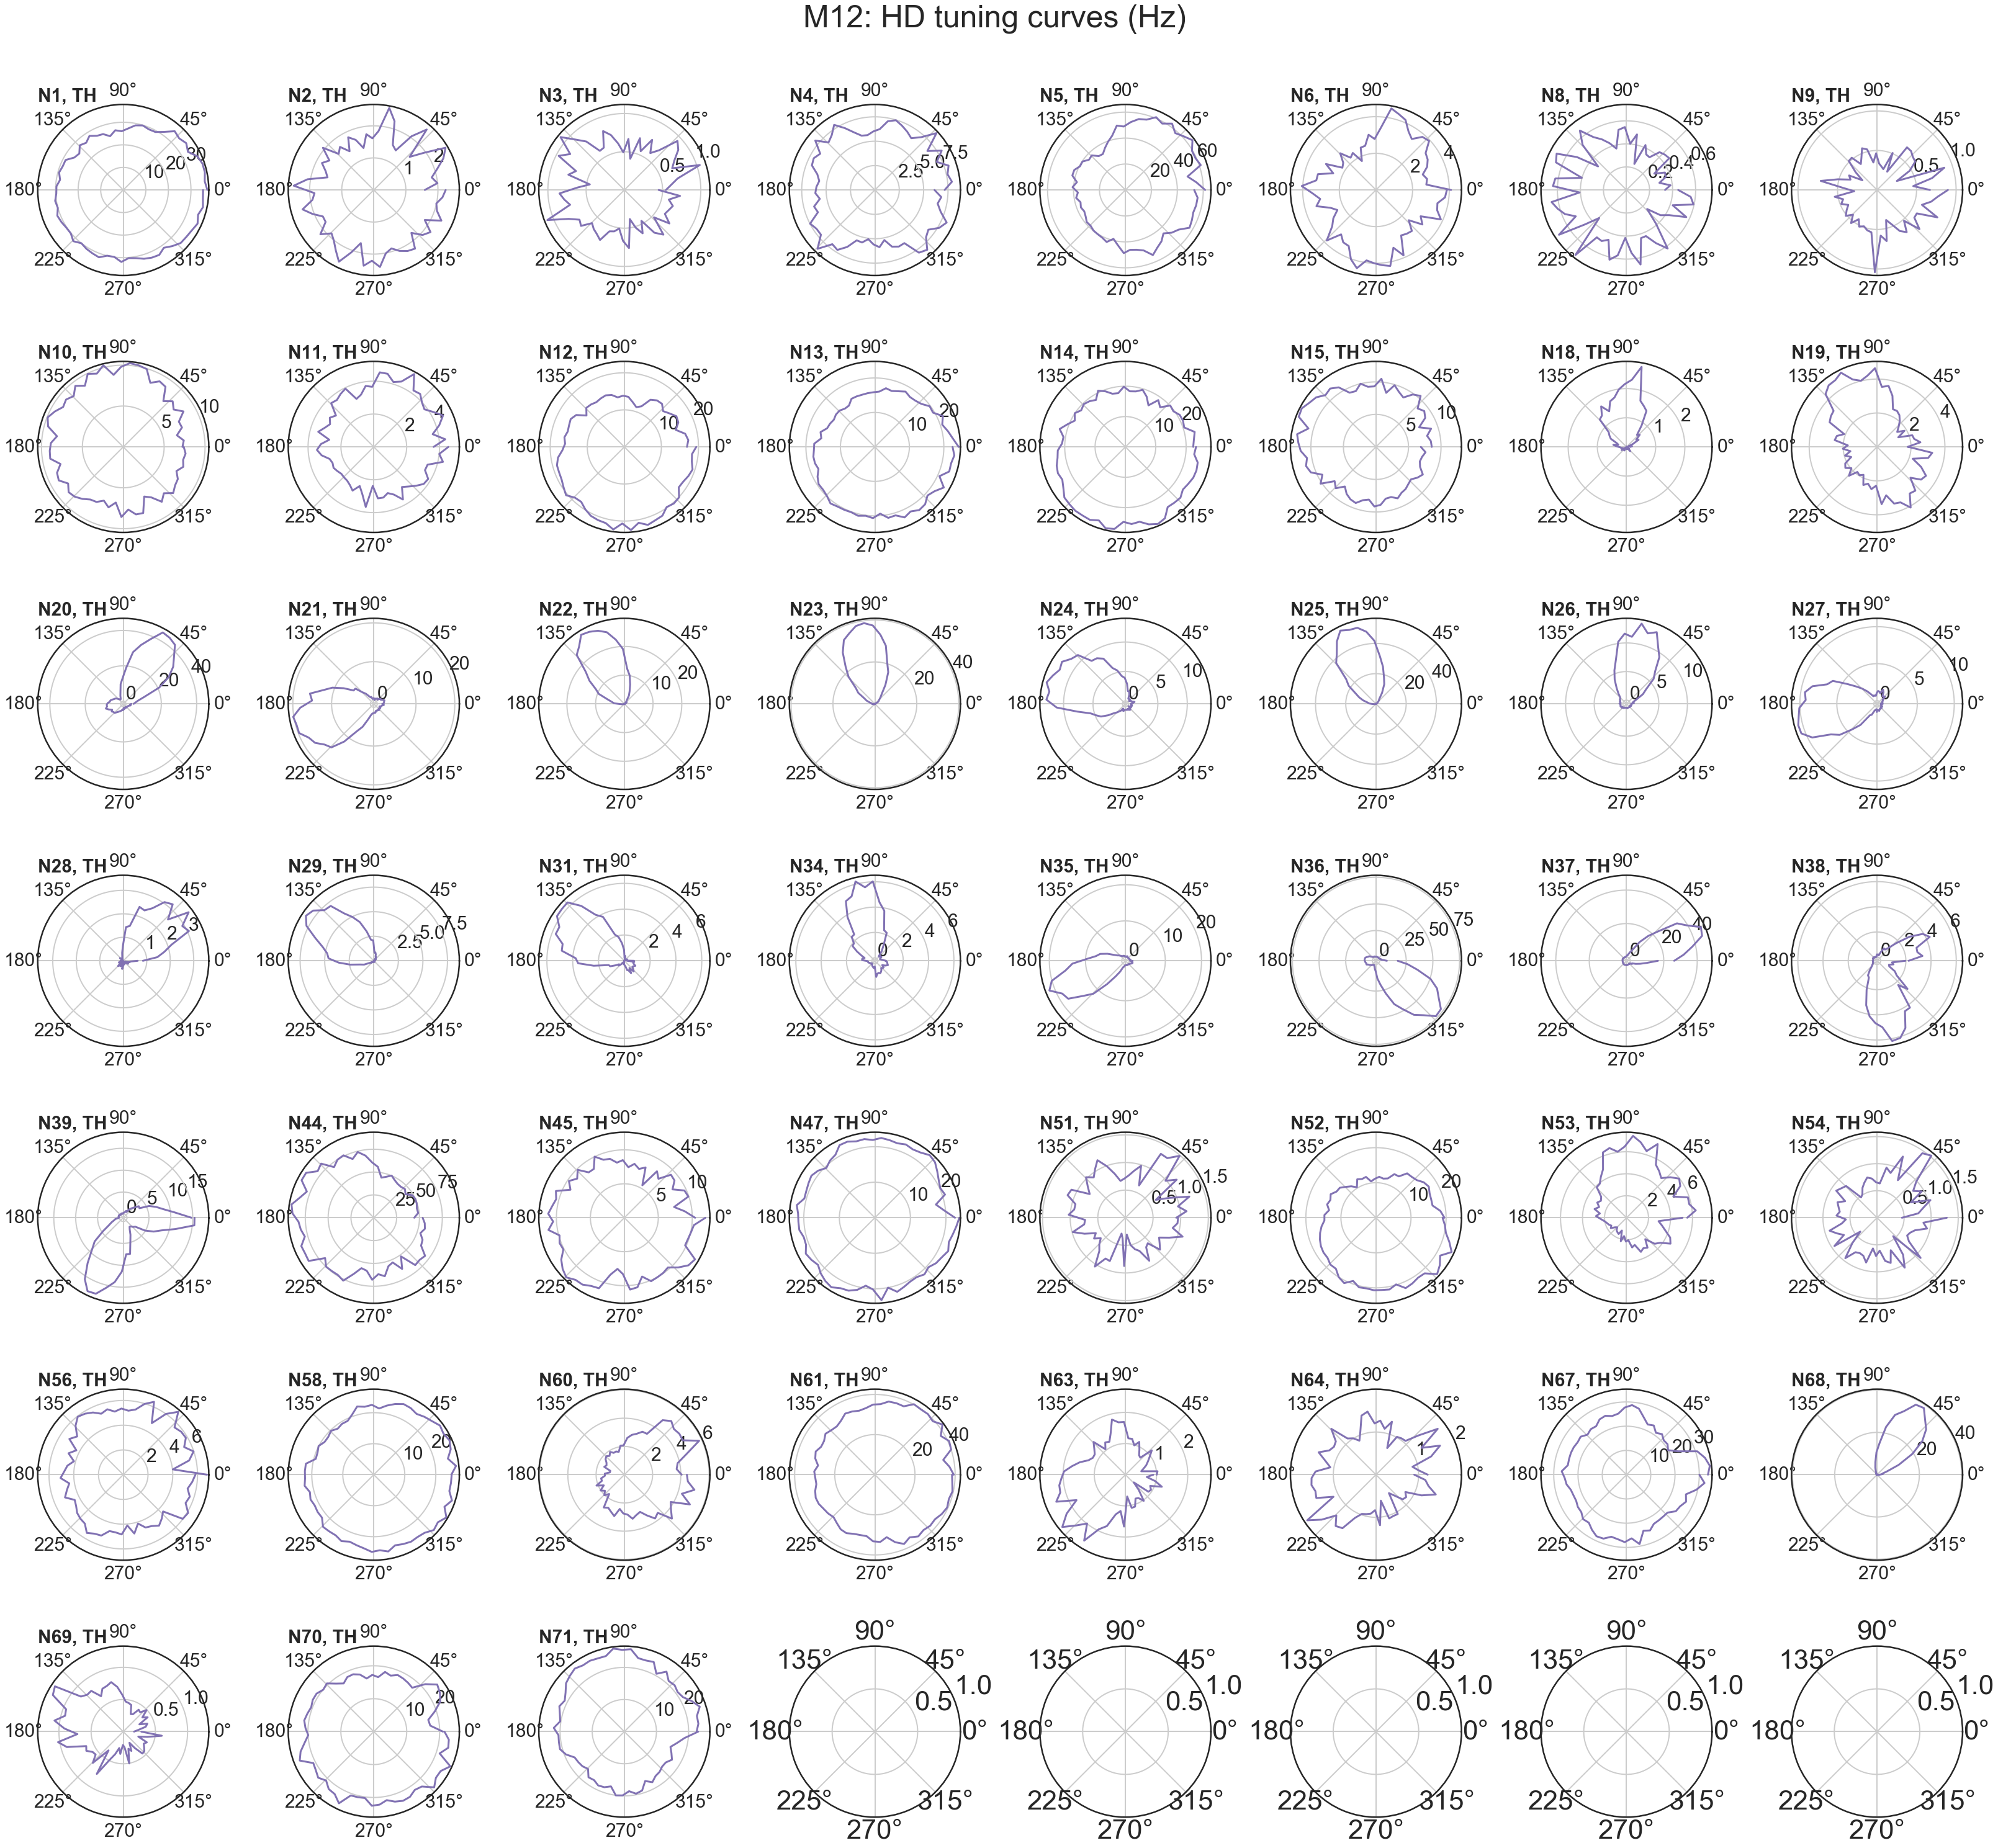

In [215]:
# save shape of SPKperAngle in an array
[F, G] = np.shape(SPKperAngle)

# Create array of subplots
fig, axes = plt.subplots(7, 8, subplot_kw=dict(projection='polar'), figsize = (45,40))
fig.tight_layout(h_pad= 4.0)
fig.suptitle("M12: HD tuning curves (Hz)", fontsize=50, ha='center', va='top')
plt.style.use('ggplot')
make_space_above(axes, topmargin=3.0)


# plot all HD tuning curves
for i, ax in enumerate(axes.flat):
    if i <= len(hdEdges)-1:
        # plot each neuron's HD tuning curve
        ax.plot(hdEdges[i], hdTuning[i], color = 'm', linewidth = 3)

        # format subplot
        ax.yaxis.get_major_locator().base.set_params(nbins=4) # reduce number of y-ticks
        ax.tick_params(labelsize = 30)
        ax.set_title('N{}, {}'.format(int(neuronInfo[i][0]), neuronInfo[i][2]), loc='left', fontsize=30, fontweight='bold')

# save figure as .png file
plt.savefig('mouse12_tuning.png')

### Plot occupancy and tuning curves for select units:

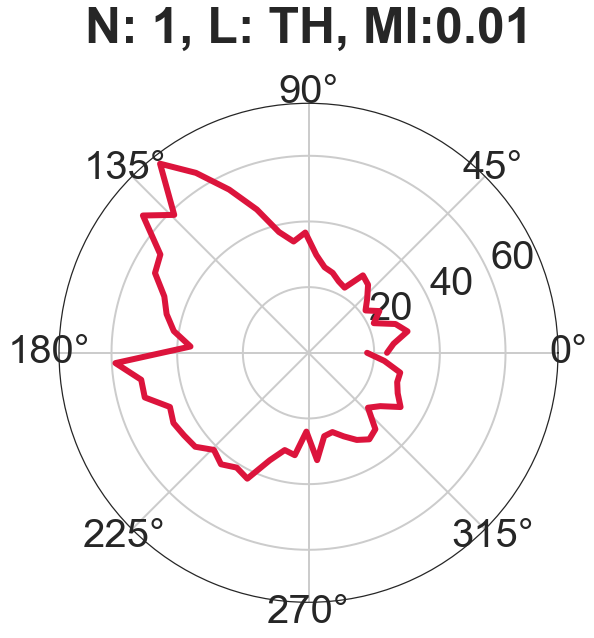

In [217]:
# plot angular occupancy (M12)
angularOccupancyPlot(1)
plt.savefig('M12_occ.png')
# plt.savefig('M28_occ.png')

In [212]:
# manual selection: units of interest

# FOR MOUSE 28:
# units with multiple peaks
tuningCurves(8) # PS
plt.savefig('M28_N8.png')
tuningCurves(3) # PS
plt.savefig('M28_N3.png')
tuningCurves(63) # TH
plt.savefig('M28_N63.png')

# units w/ multiple peaks
tuningCurves(25) # PS
plt.savefig('M28_N25.png')
tuningCurves(38) # PS
plt.savefig('M28_N38.png')

tuningCurves(60) # TH
plt.savefig('M28_N60.png')
tuningCurves(61) # TH
plt.savefig('M28_N61.png')

In [186]:
## FOR MOUSE 12:

# units w/ 'peculiar firing'
tuningCurves(38) # TH
plt.savefig('M12_N38.png')
tuningCurves(39) #TH
plt.savefig('M12_39.png')

## Part II: Principal Components Analysis (PCA)

### Reduce dimensionality of data and visualize with PCA:

In [218]:
# convert dictionary to pandas df (I find these easier to work with)
X = pd.DataFrame.from_dict(spikesDict)
X.head()

,N1,N2,N3,N4,N5,N6,N8,N9,N10,N11,...,N58,N60,N61,N63,N64,N67,N68,N69,N70,N71
0,-0.853832,-1.183703,0.239719,1.519960,-0.123065,-0.133785,-0.666413,3.306204,-0.281528,0.038926,...,0.163650,-0.122094,-0.773834,-0.484233,-0.599475,-1.144006,6.552939,-0.564410,-1.183556,-0.163958
1,-0.850912,-1.183703,0.253877,1.523060,-0.119636,-0.136562,-0.666413,3.267007,-0.274040,0.044429,...,0.169433,-0.116905,-0.763391,-0.484233,-0.599475,-1.144503,6.506595,-0.562953,-1.177955,-0.161476
2,-0.845109,-1.183703,0.281688,1.529136,-0.112912,-0.142090,-0.666413,3.189776,-0.259429,0.055181,...,0.181129,-0.106754,-0.742677,-0.484233,-0.599475,-1.145505,6.414768,-0.559960,-1.166852,-0.156430
3,-0.836278,-1.183703,0.322162,1.537938,-0.103212,-0.150244,-0.666413,3.076780,-0.238318,0.070420,...,0.198661,-0.092080,-0.712292,-0.484233,-0.599475,-1.147019,6.279160,-0.554781,-1.150412,-0.148821
4,-0.824510,-1.183703,0.373503,1.549100,-0.090942,-0.160839,-0.666413,2.931285,-0.211602,0.089552,...,0.222044,-0.073525,-0.672943,-0.484233,-0.599475,-1.149168,6.102265,-0.547942,-1.128829,-0.138619


In [219]:
# Initialize the PCA model, here specifying/preserving 3 components [or use PCA() to allow max # of PCs]
pca = PCA(n_components = 3, whiten = True)

# Fit the PCA model, and apply it to transform the data
out = pca.fit_transform(X)
principalDf = pd.DataFrame(data = out, columns = ['PC1', 'PC2', 'PC3'])
principalDf['HA'] = angle_ind
principalDf.head()

,PC1,PC2,PC3,HA
0,1.026995,2.717457,1.802552,11
1,1.037378,2.707912,1.785650,11
2,1.058007,2.689072,1.752273,12
3,1.088514,2.661316,1.703190,12
4,1.128439,2.625316,1.639573,12


In [220]:
# print explained variance ratio of first three PCs
print(pca.explained_variance_ratio_)

[0.12013408 0.09000666 0.05923938]


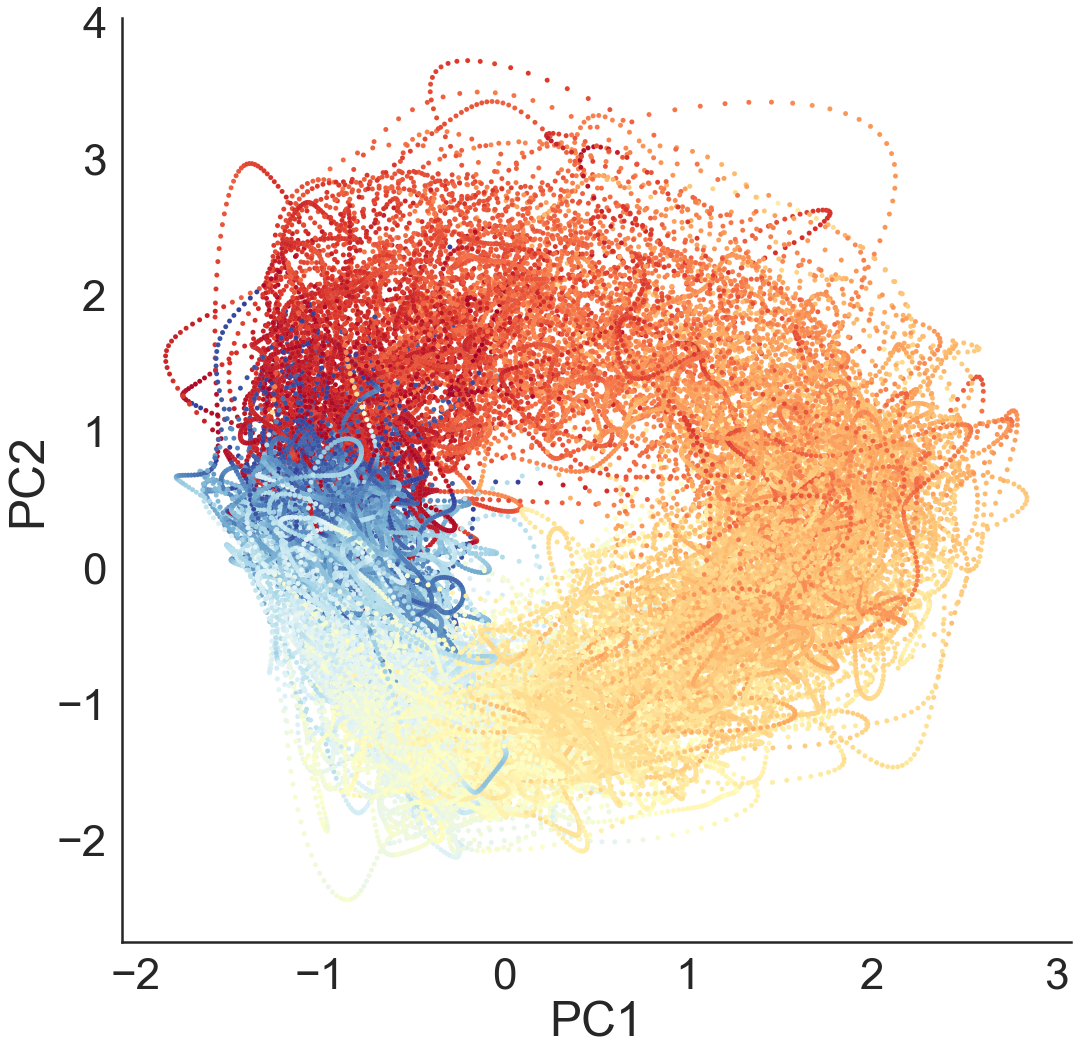

In [221]:
# visualize first two principal components

sns.set(context = 'poster', style = 'white', font_scale = 2)
fig, ax = plt.subplots(figsize=(17,17))
sns.scatterplot(x="PC1", y="PC2", hue='HA', linewidth = .05, s=25, data=principalDf, palette='RdYlBu')
ax.legend_.remove()
sns.despine()
plt.savefig('M12_PCA.png')

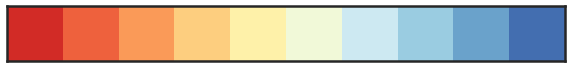

In [222]:
# rig a colorbar (shameful)

sns.palplot(sns.color_palette("RdYlBu", 10))
plt.savefig('colorbar.png')